<a href="https://colab.research.google.com/github/HappyJJins/Jeju_CreditCard/blob/master/submission0709.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive

ROOT = '/content/drive'
drive.mount(ROOT)

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from os.path import join

MY_GOOGLE_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks/Jeju'
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Jeju/data/jeju_data_ver1/submission.csv')
submission.to_gbq(destination_table='jeju_data_ver1.submission', 
                  project_id='jeju-282707', 
                  if_exists='replace')
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Jeju/data/jeju_data_ver1/201901-202003.csv')
train.to_gbq(destination_table='jeju_data_ver1.201901_202003_train', 
                  project_id='jeju-282707', 
                  if_exists='replace')

In [ ]:
import pandas as pd
from pandas.io import gbq
from google.cloud import bigquery
from tabulate import tabulate
from pandas_profiling import ProfileReport

In [ ]:
project_id = 'jeju-282707'
client = bigquery.Client(project=project_id)

train = client.query('''
  SELECT 
      * 
  FROM `jeju-282707.jeju_data_ver1.201901_202003_train` 
  WHERE RAND() < 10000 / (SELECT COUNT(*) FROM `jeju-282707.jeju_data_ver1.201901_202003_train`)
  ''').to_dataframe()

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, title='Pandas Profiling Report', explorative=True)
profile.to_notebook_iframe()

### II. 데이터 사전 준비

#### (1) 머신러닝 & 시각화 & 통계 패키지 Loading

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt  # Matlab-style plotting

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# 06 Chapter 추가
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201908,강원,삼척시,기타 대형 종합 소매업,강원,삼척시,10s,2,1,8,115720,12
1,201904,강원,강릉시,기타 대형 종합 소매업,강원,삼척시,20s,2,1,5,85710,6
2,201907,강원,속초시,차량용 주유소 운영업,강원,속초시,20s,2,2,48,2777804,75
3,201902,서울,광진구,서양식 음식점업,강원,양양군,20s,2,1,3,57600,3
4,201902,경기,용인시 처인구,전시 및 행사 대행업,강원,철원군,20s,1,1,10,196700,17
...,...,...,...,...,...,...,...,...,...,...,...,...
9848,201901,제주,서귀포시,한식 음식점업,충북,청주시 상당구,50s,2,4,9,835500,14
9849,201912,충남,천안시 서북구,빵 및 과자류 소매업,충북,음성군,50s,1,4,3,88500,4
9850,201912,충남,홍성군,체인화 편의점,충북,청주시 상당구,50s,1,4,4,39000,5
9851,202003,경기,이천시,한식 음식점업,충북,충주시,50s,1,4,112,3558970,163


*   CARD_SIDO_NM : 카드이용지역_시도 (가맹점 주소 기준)
*   CARD_CCG_NM : 카드이용지역_시군구 (가맹점 주소 기준)
*   STD_CLSS_NM : 업종명
*   HOM_SIDO_NM : 거주지역_시도 (고객 집주소 기준)
*   HOM_CCG_NM : 거주지역_시군구 (고객 집주소 기준)
*   SEX_CTGO_CD : 성별 (1: 남성, 2: 여성)
*   FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
*   CSTMR_CNT : 이용고객수 (명)
*   AMT : 이용금액 (원)
*   CNT : 이용건수 (건)

#### (2) 날짜 데이터 전처리

In [ ]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [ ]:
# 날짜 처리
data = train.copy()
data = data.fillna('')
data['REG_YYMM'].head()

0    201912
1    201903
2    201906
3    201907
4    201908
Name: REG_YYMM, dtype: int64

In [ ]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,서울,구로구,한식 음식점업,강원,강릉시,10s,1,1,3,24900,3,2019,12
1,서울,광진구,피자 햄버거 샌드위치 및 유사 음식점업,강원,화천군,20s,2,1,3,15900,3,2019,3
2,서울,서초구,비알콜 음료점업,강원,속초시,20s,2,2,10,76300,11,2019,6
3,서울,마포구,비알콜 음료점업,강원,동해시,20s,2,1,11,141300,21,2019,7
4,강원,원주시,일식 음식점업,강원,동해시,20s,2,1,3,109200,4,2019,8


#### (3) 시군구 컬럼 제거

In [ ]:
# 데이터 정제
df = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [ ]:
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
0,강원,건강보조식품 소매업,강원,50s,1,4,2019,10,37,4106500,42
1,강원,골프장 운영업,강원,20s,1,1,2019,5,3,162300,4
2,강원,골프장 운영업,경기,30s,1,2,2019,12,3,361900,4
3,강원,골프장 운영업,경기,40s,1,3,2019,7,39,3912230,81
4,강원,골프장 운영업,경기,40s,1,3,2019,9,4,368000,4


#### (4) 라벨 인코딩

* 사이킷런의 ML알고리즘은 결측치가 허용되지 않는다.
* 사이킷런의 ML알고리즘은 문자열 값을 입력 값으로 허용하지 않는다.
    * 따라서, 이를 숫자형으로 변환해야 한다.
    * 이를 데이터 인코딩이라 부른다.
* 데이터 인코딩에는 크게 두가지 있다.
    * 레이블 인코딩 VS. 원-핫 인코딩
* 레이블 인코딩은 카테고리 피처를 코드형 숫자 값으로 변환한다.
    * 이 때, 일괄적으로 숫자로 변환이 되면 선형회귀와 같은 ML알고리즘에는 적용하지 않는다. 이유는 숫자 값의 경우 크고 작음에 대한 특성이 작용한다.
    * 그러나, 본 예제에서는 주로 트리 계열을 알고리즘을 사용할 것이기 때문에 크게 상관은 없다.
* 원핫 인코딩은 피처 값의 유형에 따라 새로운 피처를 추가해 고유 값에 해당하는 칼럼에만 1을 표시하고 나머지 칼럼에는 0을 표시한다.
본 실습에서는 주로 라벨 인코딩만 사용하고 진행해본다.

In [ ]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

#### (5) 데이터셋 분리

* X_data : 독립변수
    * CARD_SIDO_NM : 카드이용지역_시도 (가맹점 주소 기준)
    * STD_CLSS_NM : 업종명
    * HOM_SIDO_NM : 거주지역_시도 (고객 집주소 기준)
    * AGE : 연령대
    * SEX_CTGO_CD : 성별
    * FLC : 가구생애주기
    * year
    * month

* y_data : 종속변수
    * AMT : 이용금액

* X_data와 y_data를 train(훈련데이터)와 test(검증데이터)를 7:3 비율로 분리

In [ ]:
from sklearn.model_selection import train_test_split

X_data, y_data = df_num.loc[:, df_num.columns != 'AMT'], df.loc[:, df_num.columns == 'AMT']
y_target = y_data['AMT']
X_data = X_data.drop(['CSTMR_CNT', 'CNT'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=126, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6567, 8), (6567,), (2815, 8), (2815,))

#### (6) 종속 변수 확인


 mu = 2628243.71 and sigma = 18702070.45



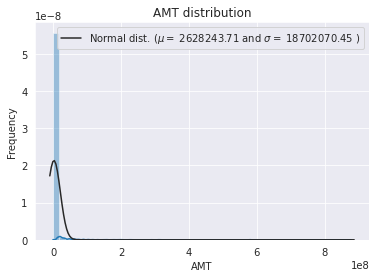

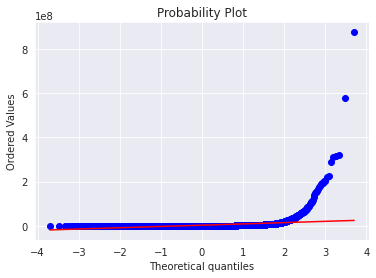

In [ ]:
sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

* 종속변수를 정규분포에 적합시켰을 때 분산이 상당히 크고 한 쪽으로 치우쳐 있음을 확인
* Q-Q plot을 보아도 정규화 작업이 필요함을 알 수 있음

종속 변수의 로그변환을 통한 정규화


 mu = 12.64 and sigma = 1.74



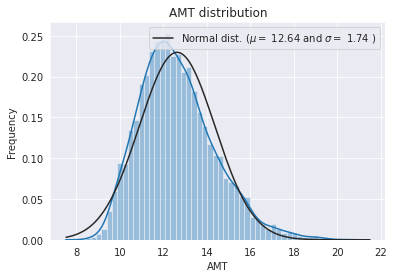

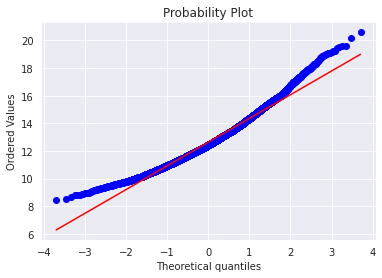

In [ ]:
y_train = np.log1p(y_train)

sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

* 로그변환 후 정규분포에 상당히 가까워졌음

### III. GBM, XGBoost, Lightgbm의 개요 및 실습

#### (2) XGboost 설치

In [ ]:
from xgboost import XGBRegressor
import xgboost
print(xgboost.__version__)

0.90


#### (3) XGboost 기본 실습

In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split

# 데이터 수집
from sklearn.datasets import load_boston

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 데이터 수집
boston = load_boston()
x, y = boston.data, boston.target

# 데이터 분리
X_train, X_test, y_train, y_test=train_test_split(x, y, test_size=0.15, random_state = 1)

xgb_reg = XGBRegressor(verbosity=0) 
print(xgb_reg)

xgb_reg.fit(X_train, y_train)
score = xgb_reg.score(X_train, y_train)  
print("Training score: ", score)

y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
Training score:  0.9749120480780799
MSE: 7.22


#### (5) LightGBM 설치

In [ ]:
import lightgbm
from lightgbm import LGBMRegressor
print(lightgbm.__version__)

2.2.3


#### (6) LightGBM 실습

In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split

# 데이터 수집
from sklearn.datasets import load_boston

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 데이터 수집
boston = load_boston()
x, y = boston.data, boston.target

# 데이터 분리
X_training, X_testing, y_training, y_testing = train_test_split(x, y, test_size=0.15, random_state = 1)

lgb_reg = LGBMRegressor(verbosity=0) 
print(lgb_reg)

lgb_reg.fit(X_training, y_training)
score = lgb_reg.score(X_training, y_training)  
print("Training score: ", score)

y_pred = lgb_reg.predict(X_testing)
mse = mean_squared_error(y_testing, y_pred)
print("MSE: %.2f" % mse)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              verbosity=0)
Training score:  0.9799082762820248
MSE: 9.44


### IV. 스태킹(Stacking) 알고리즘

#### (1) 스태킹 알고리즘 개념 예제

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_training , X_testing , y_training , y_testing = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)

# 개별 모델들을 학습. 
knn_clf.fit(X_training, y_training)
rf_clf.fit(X_training , y_training)
dt_clf.fit(X_training , y_training)
ada_clf.fit(X_training, y_training)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_testing)
rf_pred = rf_clf.predict(X_testing)
dt_pred = dt_clf.predict(X_testing)
ada_pred = ada_clf.predict(X_testing)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_testing, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_testing, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_testing, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_testing, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561 :


In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

lr_final.fit(pred, y_testing)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_testing , final)))

(4, 114)
(114, 4)
최종 메타 모델의 예측 정확도: 0.9649


### V. 교차검증 및 하이퍼 파라미터 튜닝

#### (3) RMSLE 성능 평가 방법

In [ ]:
def rmsle(y, pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('Test Data RMSLE: {0:.3f}'.format(rmsle))

#### (6) 모형 선언 및 학습

* GridSearchCV : 그리드를 사용한 복수 하이퍼 파라미터 최적화
    * 클래스 객체에 fit 메서드를 호출하면 grid search를 사용하여 자동으로 복수개의 내부 모형을 생성하고 이를 모두 실행시켜서 최적 파라미터를 찾아준다.
* 생성된 복수개와 내부 모형과 실행 결과는 다음 속성에 저장된다.
    * grid_scores_ : param_grid 의 모든 파리미터 조합에 대한 성능 결과. 각각의 원소는 다음 요소로 이루어진 튜플이다.
    * parameters: 사용된 파라미터
    * mean_validation_score : 교차 검증(cross-validation) 결과의 평균값
    * cv_validation_scores : 모든 교차 검증(cross-validation) 결과
    * best_score_ : 최고 점수
    * best_params_ : 최고 점수를 낸 파라미터
    * best_estimator_ : 최고 점수를 낸 파라미터를 가진 모형

**Booster Parameters**

* eta [default=0.3]
  * Analogous to learning rate in GBM
Makes the model more robust by shrinking the weights on each step
Typical final values to be used: 0.01-0.2
* min_child_weight [default=1]
    * Defines the minimum sum of weights of all observations required in a child.
This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
Too high values can lead to under-fitting hence, it should be tuned using CV.
* max_depth [default=6]
The maximum depth of a tree, same as GBM.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.
Typical values: 3-10
* max_leaf_nodes
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
If this is defined, GBM will ignore max_depth.
* gamma [default=0]
A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
* max_delta_step [default=0]
In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
This is generally not used but you can explore further if you wish.
* subsample [default=1]
Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
Typical values: 0.5-1
* olsample_bytree [default=1]
Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
Typical values: 0.5-1
* colsample_bylevel [default=1]
Denotes the subsample ratio of columns for each split, in each level.
I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so.
* lambda [default=1]
L2 regularization term on weights (analogous to Ridge regression)
This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.
* alpha [default=0]
L1 regularization term on weight (analogous to Lasso regression)
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
* scale_pos_weight [default=1]
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.

In [ ]:
# 교차검증 수행
def get_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv = 5)
  cv_model.fit(X_train, y_train)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test)
  eval_pred = np.expm1(eval_pred)
  rmsle(y_test, eval_pred)
  
  return cv_model.best_estimator_

In [ ]:
from sklearn.linear_model import LinearRegression

# 4개의 모델 선언
xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0)  

params = {'n_estimators': [1000, 2000]}

models = [xgb, gbm, lgb] # 모형 하나 추가 함
best_models = []
for model in models:
  new_model = get_best_params_model(model=model, params=params)
  best_models.append(new_model)

[01:59:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:00:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:00:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:00:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:00:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:00:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:00:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:00:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

#### (7) 스태킹 알고리즘 테스트

In [ ]:
# 모형 불러오기
xgb_reg = best_models[0]
gbm_reg = best_models[1]
lgb_reg = best_models[2]

# 예측 데이터 세트
xgb_pred = xgb_reg.predict(X_test)
xgb_pred = np.expm1(xgb_pred)

gbm_pred = gbm_reg.predict(X_test)
gbm_pred = np.expm1(gbm_pred)

lgb_pred = lgb_reg.predict(X_test)
lgb_pred = np.expm1(lgb_pred)

pred = np.array([xgb_pred, gbm_pred, lgb_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환
pred = np.transpose(pred)
print(pred.shape)

(3, 2815)
(2815, 3)


In [ ]:
final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20
rmsle(y_test, final)

Test Data RMSLE: 1.481


#### (8) 예측 템플릿 작성

In [ ]:
from itertools import product

# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs,HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))

train_features = df_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
temp = pd.DataFrame(data=temp, columns=train_features.columns)

In [ ]:
# 예측 데이터 세트
xgb_pred = xgb_reg.predict(temp)
xgb_pred = np.expm1(xgb_pred)

gbm_pred = gbm_reg.predict(temp)
gbm_pred = np.expm1(gbm_pred)

lgb_pred = lgb_reg.predict(temp)
lgb_pred = np.expm1(lgb_pred)

In [ ]:
final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20

temp['AMT'] = np.round(final, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [ ]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [ ]:
print(temp.head())

   REG_YYMM CARD_SIDO_NM        STD_CLSS_NM          AMT
0    202004           강원         건강보조식품 소매업  146172558.0
1    202004           강원            골프장 운영업  292348090.0
2    202004           강원        과실 및 채소 소매업   56831593.0
3    202004           강원  관광 민예품 및 선물용품 소매업   13638913.0
4    202004           강원    그외 기타 스포츠시설 운영업   13640486.0


#### (9) Submission 파일 작업 및 내보내기

In [ ]:
submission = client.query('''
  SELECT 
    * 
  FROM `jeju-282707.jeju_data_ver1.submission` 
  ''').to_dataframe()

In [ ]:
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission['AMT'] = submission['AMT'].fillna(0)
print(submission.head())

   id  REG_YYMM CARD_SIDO_NM           STD_CLSS_NM          AMT
0   0    202004           강원            건강보조식품 소매업  146172558.0
1   1    202004           강원               골프장 운영업  292348090.0
2   2    202004           강원           과실 및 채소 소매업   56831593.0
3   3    202004           강원     관광 민예품 및 선물용품 소매업   13638913.0
4   4    202004           강원  그외 기타 분류안된 오락관련 서비스업          0.0


In [ ]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/Jeju/submission.csv', encoding='utf-8-sig', index=False)